In [10]:
from influxdb import InfluxDBClient
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from ruamel.yaml import YAML
import streamlit as st
import datetime as dt

In [11]:
with open("secrets.yaml", "r") as file:
    secrets = YAML().load(file)

client = InfluxDBClient(host=secrets["influx"]["host"], 
                        port=secrets["influx"]["port"], 
                        username=secrets["influx"]["username"], 
                        password=secrets["influx"]["password"])

client.get_list_database()

[{'name': '_internal'},
 {'name': 'influx_db_1'},
 {'name': 'influx_db_2'},
 {'name': 'influx_db_3'},
 {'name': 'influx_db_4'}]

In [12]:
databases = [item["name"] for item in client.get_list_database()]
databases

['_internal', 'influx_db_1', 'influx_db_2', 'influx_db_3', 'influx_db_4']

In [13]:
client.switch_database('influx_db_4')

In [14]:
records = list()
for point in ["unit=" + p["key"] for p in client.query("show series").get_points()]:
    # point example: unit=kWh,domain=sensor,entity_id=sma_battery_charge_total
    record = dict()
    for item in point.split(","):
        key, value = item.split("=")
        record[key] = value
    records.append(record)
entities = pd.DataFrame.from_records(records)

In [15]:
entities.unit.value_counts().sort_index()

unit
%                     52
A                     19
B                      3
GB                     1
GiB                    2
Hz                     2
Mbit/s                 2
MiB                    2
UV\ index              1
V                      6
W                     46
Wh                     2
dBm                    3
h                      1
hPa                    2
kW                     1
kWh                   17
kWh/100km              1
km                     4
km/h                   2
l                      2
lx                     2
m                      1
min                    3
mm                     3
mm/h                   2
ms                     1
m³                     6
m³/h                   3
pending\ update(s)     1
s                      4
state                 64
steps                  1
°                      3
°C                    24
µS/cm                  2
Name: count, dtype: int64

In [16]:
entities[entities.unit == "m³"]

,unit,domain,entity_id
183,m³,sensor,gasmeter2_rate_per_digitalization_round
184,m³,sensor,gasmeter2_value
185,m³,sensor,gasmeter_rate_per_digitalization_round
186,m³,sensor,gasmeter_value
187,m³,sensor,watermeter_rate_per_digitalization_round
188,m³,sensor,watermeter_value


In [81]:
next(iter(entities[entities["entity_id"] == "watermeter_cputemp"]["unit"]))

'°C'

In [ ]:
w

In [21]:
unit = "m³"
entity_id = "watermeter_value"
selection = "mean_value"
qstr = f'SELECT {selection} FROM "{unit}" WHERE {entity_id=}'
df = pd.DataFrame.from_records(client.query(qstr).get_points())
df.tail(2)


,time,mean_value
2087,2024-04-08T11:00:00Z,608.4674
2088,2024-04-08T15:00:00Z,608.4740


In [25]:
start_date = dt.datetime(2024,1,1).date()
start_time = dt.time(12, 0, 0)
start_datetime = dt.datetime.combine(start_date, start_time)

In [68]:
rfc3339_format = '%Y-%m-%dT%H:%M:%S.00000000Z'
start_string = dt.datetime.combine(start_date, start_time).strftime(rfc3339_format)

In [69]:
unit = "m³"
entity_id = "watermeter_value"
selection = "mean_value"
qstr = f"""SELECT {selection} FROM "{unit}" WHERE {entity_id=} AND time >= '{start_string}'"""
qstr

'SELECT mean_value FROM "m³" WHERE entity_id=\'watermeter_value\' AND time >= \'2024-01-01T12:00:00.00000000Z\''

In [82]:
df = pd.DataFrame.from_records(client.query(qstr).get_points()).set_index("time")
df

,mean_value
time,
2024-01-01T12:00:00Z,591.116700
2024-01-01T13:00:00Z,591.147960
2024-01-01T14:00:00Z,591.167750
2024-01-01T15:00:00Z,591.204033
2024-01-01T16:00:00Z,591.212400
...,...
2024-04-08T15:00:00Z,608.474000
2024-04-08T16:00:00Z,608.480000
2024-04-08T17:00:00Z,608.488400


In [18]:
df["datetime"] = pd.to_datetime(df.time)
df["date"] = [t.date() for t in df.datetime]
df["time"] = [t.time() for t in df.datetime]
df["diff"] = df["mean_value"].diff()
df

,time,mean_value,datetime,date,diff
2087,11:00:00,608.4674,2024-04-08 11:00:00+00:00,2024-04-08,0.026117
2088,15:00:00,608.4740,2024-04-08 15:00:00+00:00,2024-04-08,0.006600


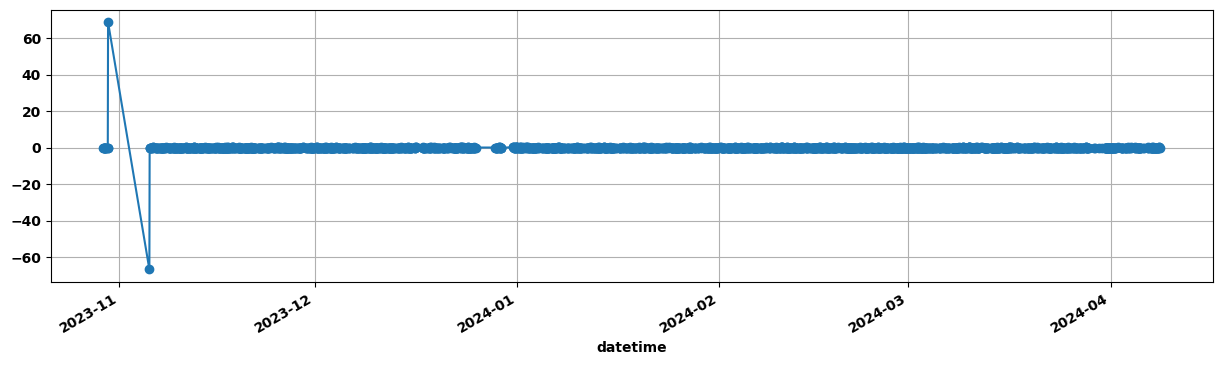

In [19]:
%matplotlib inline
df.set_index("datetime")["diff"].plot(figsize=(15,4), grid=True, marker="o");

In [14]:
pt = df.pivot_table(values="diff", columns="date", index="time")
pt.tail(2)

date,2023-10-29,2023-10-30,2023-11-05,2023-11-06,2023-11-07,2023-11-08,2023-11-09,2023-11-10,2023-11-11,2023-11-12,...,2024-03-19,2024-03-20,2024-03-21,2024-03-22,2024-03-23,2024-03-24,2024-03-25,2024-03-26,2024-03-27,2024-03-28
time,,,,,,,,,,,,,,,,,,,,,
22:00:00,NaN,NaN,NaN,0.0092,0.0037,0.0075,0.0022,NaN,NaN,0.0012,...,0.0,0.0018,NaN,0.00345,0.01295,0.005433,NaN,NaN,NaN,NaN
23:00:00,0.0072,NaN,0.0043,NaN,NaN,NaN,NaN,NaN,0.0039,NaN,...,0.0,NaN,NaN,NaN,NaN,0.001000,NaN,NaN,NaN,NaN


In [65]:
mpl.cm.RdYlGn

<module 'matplotlib.cm' from 'c:\\Users\\holge\\anaconda3\\envs\\influx\\Lib\\site-packages\\matplotlib\\cm.py'>

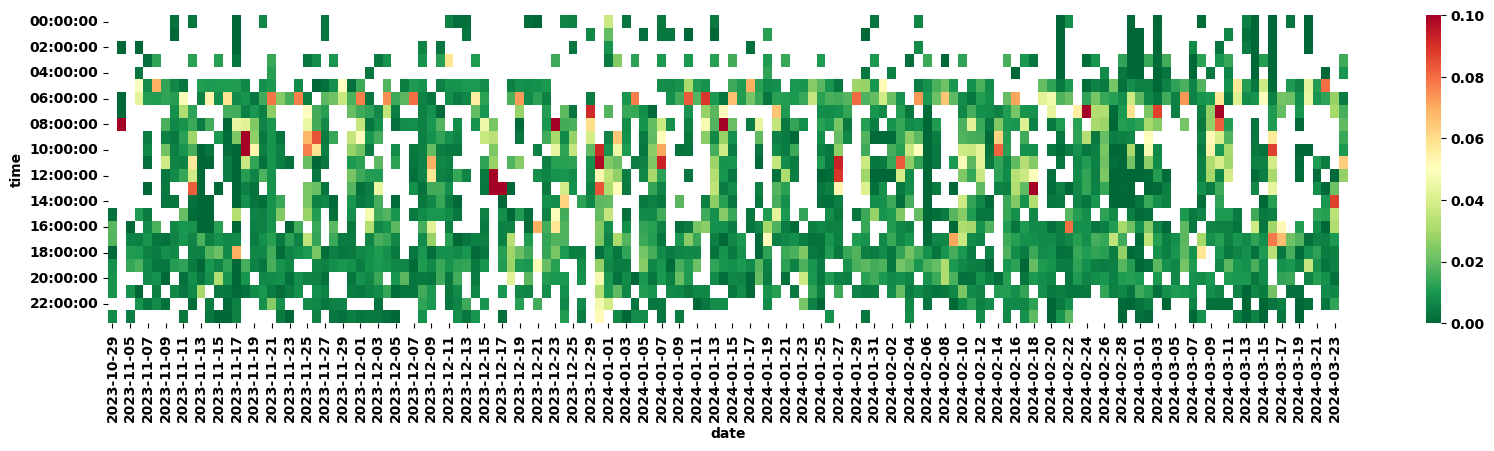

In [69]:
plt.figure(figsize=(20,4))
sns.heatmap(pt, cmap=mpl.cm.RdYlGn_r, vmin=0, vmax=.1);

In [31]:
pt.max().max(), pt.min().min()

(1.2284, -0.4442345)

In [ ]:
pt.index = [t.hour for t in pt.index]
pt.columns = [i for i in range(len(pt.columns))]
ny, nx = pt.values.shape
y = np.vstack(nx*[pt.index.values]).T
x = np.vstack(ny*[pt.columns.values])

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x,y, pt.values, cmap=mpl.cm.OrRd_r,
                       linewidth=0, antialiased=False)
plt.show;

In [9]:
dt.datetime.now().date() - dt.timedelta(days=365)

datetime.date(2023, 4, 8)